# COGS516 - Assignment 5

In [1]:
student = {
    'name' : "Abdullah Burkan" ,
    'surname' : "Bereketoğlu", 
    'studentNumber' : "2355170"
}

print(student)

{'name': 'Abdullah Burkan', 'surname': 'Bereketoğlu', 'studentNumber': '2355170'}


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import arviz as az
from scipy import stats
from graphviz import Digraph
from matplotlib.lines import Line2D
from IPython.display import Image

## Balloon Analogue Risk Task
In this assignment you are given a dataset from an experiment on the risk taking behavior of humans. The task in the experiment is the Balloon Analogue Risk Task (BART). Participants are presented with virtual balloons through a computer screen. Inflating a balloon increases the amount of reward a participant gets, but they need to stop and cash-in before the balloon bursts. If the balloon bursts, then the offered reward is not added to the total. The goal is to maximize the total reward (see this [video](https://www.youtube.com/watch?v=foy3ZVokjFM) for an example). In this experiment, however, there are balloons of different colors: red, blue, and green. The experiment is designed such that at each trial the program draws an integer from a discrete uniform distribution, which defines the number of pumps at which the balloon will burst at that trial. Distributions for each color is as follows:
$$
maxPump_{red} \sim \text{discreteUniform}(1,16)
\\
maxPump_{green} \sim \text{discreteUniform}(1,32)
\\
maxPump_{blue} \sim \text{discreteUniform}(1,64)
$$
Have a look at the first few rows of the dataset below. For participant #1 we can follow the sequence: the first balloon was blue, and the participant pumped it 20 times, and then cahsed-in without a burst, leading to a gain of 20*5=100 points (i.e. reward). Then it was a green balloon, the subject tried to pump it but the balloon burst at the very first step, so the total was the same. It was the same for the next, the red one. It was followed by a blue balloon with 29 pumps, no burst, 145 gain, leading to total 100+145=245. The green one that followed was pumped 5 times, but at the $6^{th}$ pump it burst.

In [3]:
d = pd.read_csv('BART_data.csv')
d.head()

,subjectId,trialNum,color,nPump,burst,gain,total
0,1,1,blue,20,0,100,100
1,1,2,green,0,1,0,100
2,1,3,red,0,1,0,100
3,1,4,blue,29,0,145,245
4,1,5,green,5,1,0,245


# Data Overview [15pts]

**a.** What are the total scores for each participant? Draw a scatter plot where x-axis is the participant ID (number) and the y-axis is the total score. Draw a horizontal line for the average score across all participants. Your output should look like the one below: **[5pts]**


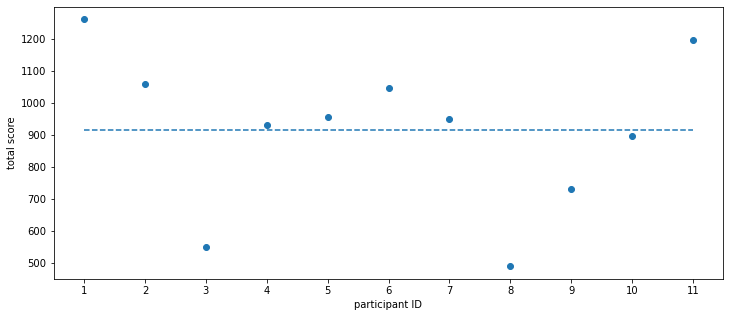

In [4]:
Image('output1.png')

In [5]:
# Write your code here
max_tot_Data = d.loc[d.total.eq(d.groupby('subjectId').total.transform('max'))]
max_tot_Data = max_tot_Data.drop_duplicates(['subjectId'], keep = 'first')

In [6]:
mean_max_tot_data = np.mean(d.loc[d.total.eq(d.groupby('subjectId').total.transform('max'))])

In [7]:
mean_max_tot_data.total

858.4615384615385

In [8]:
pd.unique(d.subjectId)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [9]:
max_tot_Data

,subjectId,trialNum,color,nPump,burst,gain,total
29,1,30,blue,23,0,115,1260
59,2,30,blue,9,0,45,1060
87,3,28,green,5,0,25,550
119,4,30,blue,10,0,50,930
149,5,30,blue,10,0,50,955
179,6,30,blue,14,0,70,1045
209,7,30,blue,6,0,30,950
239,8,30,blue,6,0,30,490
269,9,30,blue,4,0,20,730
299,10,30,blue,10,0,50,895


Text(0.5, 0, 'participant ID')

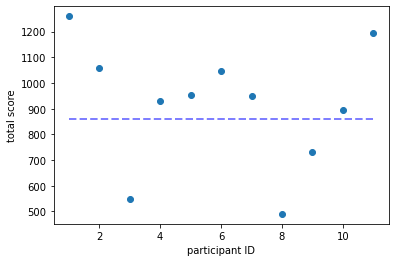

In [10]:
fig, ax = plt.subplots()
ax.scatter(pd.unique(d.subjectId), max_tot_Data.total)
y_avg = [mean_max_tot_data.total] * len(pd.unique(d.subjectId))
ax.plot(pd.unique(d.subjectId),y_avg , color='blue', lw=2, alpha = 0.5,  ls='--', label="average plot")
ax.set_ylabel("total score")
ax.set_xlabel("participant ID")

**b.** What are the average gain amounts from a trial for each subject? Draw a similar plot where this time the y-axis is the gain amount. For each mean point on the graph, include the errorbars representing the standard error. Be careful, do not to discard trials in which the balloons burst. Use standardized values. Draw the mean gain from a trial, across all participants, as a horizontal line. **[5pts]**
> Standard error of the mean: $\sigma_{\bar{x}}=\frac{\sigma}{\sqrt{n}}$ where n is the sample size and $\sigma$ is the standard deviation.

Your output should like the one below:

In [11]:
d.head()

,subjectId,trialNum,color,nPump,burst,gain,total
0,1,1,blue,20,0,100,100
1,1,2,green,0,1,0,100
2,1,3,red,0,1,0,100
3,1,4,blue,29,0,145,245
4,1,5,green,5,1,0,245


In [12]:
d["gain_stand"] = (d["gain"] - d["gain"].mean())/(d["gain"].std())

In [13]:
pd.unique(d["subjectId"])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [14]:
print(d.columns)

Index(['subjectId', 'trialNum', 'color', 'nPump', 'burst', 'gain', 'total',
       'gain_stand'],
      dtype='object')


In [15]:
len(d.loc[d["subjectId"] == 1]["gain"])

30

In [16]:
array = []
for i in pd.unique(d["subjectId"]):
    array.append(d.loc[d["subjectId"] == i]["gain_stand"].std()/np.sqrt(len(d.loc[d["subjectId"] == 1]["gain_stand"]))) # to add standard error.

In [17]:
avg_gain_Data = d.groupby('subjectId').mean()

In [18]:
avg_gain_Data

,trialNum,nPump,burst,gain,total,gain_stand
subjectId,,,,,,
1,15.5,13.300000,0.500000,42.000000,618.500000,0.338838
2,15.5,9.566667,0.266667,35.333333,559.500000,0.142668
3,15.5,5.166667,0.333333,18.333333,260.000000,-0.357563
4,15.5,8.666667,0.466667,31.000000,531.833333,0.015159
5,15.5,9.133333,0.400000,31.833333,456.333333,0.039680
6,15.5,7.733333,0.166667,34.833333,433.000000,0.127956
7,15.5,7.100000,0.266667,31.666667,492.833333,0.034775
8,15.5,3.700000,0.133333,16.333333,223.000000,-0.416414
9,15.5,5.466667,0.233333,24.333333,437.333333,-0.181011


In [19]:
avg_gain_Data["err_bar"] = array

In [20]:
avg_gain_Data

,trialNum,nPump,burst,gain,total,gain_stand,err_bar
subjectId,,,,,,,
1,15.5,13.300000,0.500000,42.000000,618.500000,0.338838,0.268486
2,15.5,9.566667,0.266667,35.333333,559.500000,0.142668,0.224843
3,15.5,5.166667,0.333333,18.333333,260.000000,-0.357563,0.100342
4,15.5,8.666667,0.466667,31.000000,531.833333,0.015159,0.287444
5,15.5,9.133333,0.400000,31.833333,456.333333,0.039680,0.153659
6,15.5,7.733333,0.166667,34.833333,433.000000,0.127956,0.147715
7,15.5,7.100000,0.266667,31.666667,492.833333,0.034775,0.140966
8,15.5,3.700000,0.133333,16.333333,223.000000,-0.416414,0.041092
9,15.5,5.466667,0.233333,24.333333,437.333333,-0.181011,0.112366


In [21]:
mean_avg_gain_Data = np.mean(avg_gain_Data["gain_stand"])

In [22]:
mean_avg_gain_Data # approximately zero.

3.532527805625498e-17

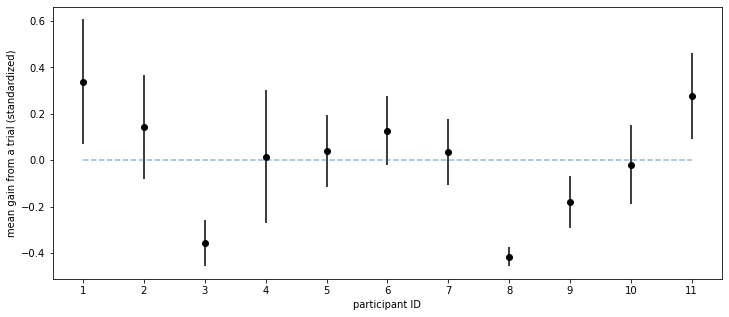

In [23]:
Image('output2.png')

Text(0.5, 0, 'participant ID')

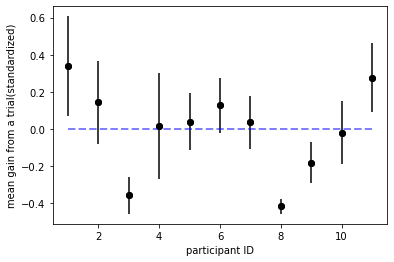

In [24]:
# Write your code here
fig, ax = plt.subplots()
ax.scatter(pd.unique(d.subjectId), avg_gain_Data.gain_stand, color = "black")
ax.errorbar(pd.unique(d.subjectId), avg_gain_Data.gain_stand, yerr = avg_gain_Data.err_bar, color= "black", fmt='o')
y_avg = [mean_avg_gain_Data] * len(pd.unique(d.subjectId))
ax.plot(pd.unique(d.subjectId),y_avg , color='blue', lw=2, alpha = 0.5,  ls='--', label="average plot")
ax.set_ylabel("mean gain from a trial(standardized)")
ax.set_xlabel("participant ID")

In [25]:
avg_gain_Data = avg_gain_Data.reset_index()

In [26]:
print(avg_gain_Data.columns)

Index(['subjectId', 'trialNum', 'nPump', 'burst', 'gain', 'total',
       'gain_stand', 'err_bar'],
      dtype='object')


**c.** Now consider the balloon color. Find the amount of average gain for each color that contributes to the total score, for each participant. Also draw the standard error of those means, for each participant and for each color. Be careful, do not to discard trials in which the balloons burst. Finally, draw the mean contribution of each balloon of different colors, across all participants (i.e three horizontal lines). Use standardized scores. **[5pts]**

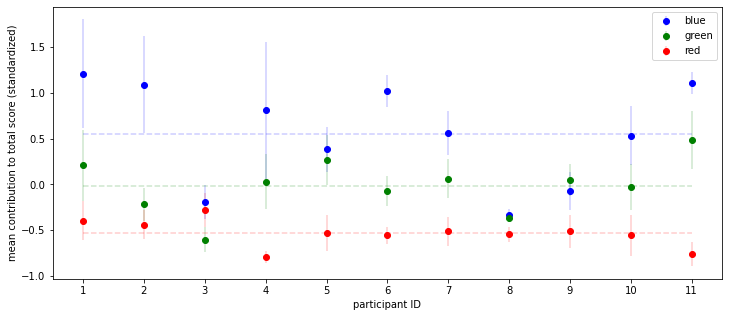

In [27]:
Image('output3.png')

In [28]:
# Write your code here
d.head()

,subjectId,trialNum,color,nPump,burst,gain,total,gain_stand
0,1,1,blue,20,0,100,100,2.045509
1,1,2,green,0,1,0,100,-0.897028
2,1,3,red,0,1,0,100,-0.897028
3,1,4,blue,29,0,145,245,3.369651
4,1,5,green,5,1,0,245,-0.897028


In [29]:
avg_color_data = d.groupby(['subjectId','color']).mean()

In [30]:
avg_color_data

trialNum  nPump  burst  gain  total  gain_stand
subjectId color                                                 
1         blue       17.2   23.4    0.4  71.5  693.0    1.206886
          green      15.0   10.0    0.5  37.5  600.0    0.206423
          red        14.3    6.5    0.6  17.0  562.5   -0.396797
2         blue       17.2   16.9    0.2  67.5  622.5    1.089184
          green      15.0    6.9    0.3  23.0  532.0   -0.220244
          red        14.3    4.9    0.3  15.5  524.0   -0.440935
3         blue       17.2    6.2    0.2  24.0  297.5   -0.190819
          green      15.0    3.5    0.5  10.0  239.5   -0.602774
          red        14.3    5.8    0.3  21.0  243.0   -0.279095
4         blue       17.2   12.3    0.3  58.0  587.5    0.809643
          green      15.0    9.1    0.4  31.5  523.0    0.029871
          red        14.3    4.6    0.7   3.5  485.0   -0.794039
5         blue       17.2   10.0    0.2  43.5  521.0    0.382976
          green      15.0    9.9    0.3  39.5  436.5    0.265274
          red        14.3    7.5    0.7  12.5  411.5   -0.529211
6         blue       17.2   13.0    0.0  65.0  525.0    1.015621
          green      15.0    6.3    0.1  28.0  392.0   -0.073118
          red        14.3    3.9    0.4  11.5  382.0   -0.558636
7         blue       17.2   10.0    0.1  49.5  552.5    0.559528
          green      15.0    6.9    0.2  32.5  458.0    0.059297
          red        14.3    4.4    0.5  13.0  468.0   -0.514498
8         blue       17.2    4.0    0.1  19.0  255.0   -0.337946
          green      15.0    3.6    0.0  18.0  212.5   -0.367371
          red        14.3    3.5    0.3  12.0  201.5   -0.543923
9         blue       17.2    6.4    0.1  28.0  471.5   -0.073118
          green      15.0    7.1    0.2  32.0  424.5    0.044584
          red        14.3    2.9    0.4  13.0  416.0   -0.514498
10        blue       17.2   11.3    0.2  48.5  518.0    0.530102
          green      15.0    8.0    0.4  29.5  402.5   -0.028980
          red        14.3    8.1    0.8  11.5  405.5   -0.558636
11        blue       17.2   13.6    0.0  68.0  617.0    1.103897
          green      15.0   11.9    0.3  47.0  520.0    0.485964
          red        14.3    6.8    0.9   4.5  477.0   -0.764614

In [31]:
array1 = []
for i in pd.unique(d["subjectId"]):
    for i1 in pd.unique(d["color"]):
        array1.append(d["gain_stand"][(d["subjectId"] == i) & (d['color'] == i1)].std()/np.sqrt(len(d["gain_stand"][(d["subjectId"] == i) & (d["color"] == i1)]))) # to add standard error.

In [32]:
array1

[0.5946262775966845,
 0.3881782487633105,
 0.21623141436894902,
 0.5296793358372023,
 0.1784492188914267,
 0.15578162933936604,
 0.18323708231767258,
 0.13871251699240694,
 0.18454500100396315,
 0.748019385932159,
 0.3039434665044359,
 0.06222767814274222,
 0.24721395991910297,
 0.27257097828379756,
 0.1952474146981034,
 0.17545899746832605,
 0.16441968595751583,
 0.0931803333307459,
 0.23870042326995267,
 0.21405143749678643,
 0.15846045845361945,
 0.06865919298054958,
 0.044947992712564167,
 0.08264752047993285,
 0.20244425368205812,
 0.17297400812238656,
 0.1784492188914267,
 0.32162913299901047,
 0.25241295311232276,
 0.22586086809015904,
 0.1225075779243376,
 0.31341048786014264,
 0.13241415789105995]

In [33]:
avg_color_data["err_bar"] = array1

In [34]:
avg_color_data = avg_color_data.reset_index()

In [35]:
avg_color_data

,subjectId,color,trialNum,nPump,burst,gain,total,gain_stand,err_bar
0,1,blue,17.2,23.4,0.4,71.5,693.0,1.206886,0.594626
1,1,green,15.0,10.0,0.5,37.5,600.0,0.206423,0.388178
2,1,red,14.3,6.5,0.6,17.0,562.5,-0.396797,0.216231
3,2,blue,17.2,16.9,0.2,67.5,622.5,1.089184,0.529679
4,2,green,15.0,6.9,0.3,23.0,532.0,-0.220244,0.178449
5,2,red,14.3,4.9,0.3,15.5,524.0,-0.440935,0.155782
6,3,blue,17.2,6.2,0.2,24.0,297.5,-0.190819,0.183237
7,3,green,15.0,3.5,0.5,10.0,239.5,-0.602774,0.138713
8,3,red,14.3,5.8,0.3,21.0,243.0,-0.279095,0.184545
9,4,blue,17.2,12.3,0.3,58.0,587.5,0.809643,0.748019


In [36]:
mean_avg_color_data = []
for i in pd.unique(d["color"]):
    mean_avg_color_data.append(np.mean(d.loc[d["color"] == i]["gain_stand"]))

In [37]:
print(avg_color_data.columns)

Index(['subjectId', 'color', 'trialNum', 'nPump', 'burst', 'gain', 'total',
       'gain_stand', 'err_bar'],
      dtype='object')


In [38]:
mean_avg_color_data # means

[0.5541777719144358, -0.018279395533782643, -0.5358983763806543]

By order the means are blue, green and red.

In [39]:
len(avg_color_data)

33

In [40]:
b = avg_color_data.loc[avg_color_data["color"] == "blue"]

In [41]:
r = avg_color_data.loc[avg_color_data["color"] == "red"]

In [42]:
g = avg_color_data.loc[avg_color_data["color"] == "green"]

In [43]:
b

,subjectId,color,trialNum,nPump,burst,gain,total,gain_stand,err_bar
0,1,blue,17.2,23.4,0.4,71.5,693.0,1.206886,0.594626
3,2,blue,17.2,16.9,0.2,67.5,622.5,1.089184,0.529679
6,3,blue,17.2,6.2,0.2,24.0,297.5,-0.190819,0.183237
9,4,blue,17.2,12.3,0.3,58.0,587.5,0.809643,0.748019
12,5,blue,17.2,10.0,0.2,43.5,521.0,0.382976,0.247214
15,6,blue,17.2,13.0,0.0,65.0,525.0,1.015621,0.175459
18,7,blue,17.2,10.0,0.1,49.5,552.5,0.559528,0.238700
21,8,blue,17.2,4.0,0.1,19.0,255.0,-0.337946,0.068659
24,9,blue,17.2,6.4,0.1,28.0,471.5,-0.073118,0.202444
27,10,blue,17.2,11.3,0.2,48.5,518.0,0.530102,0.321629


In [44]:
g

,subjectId,color,trialNum,nPump,burst,gain,total,gain_stand,err_bar
1,1,green,15.0,10.0,0.5,37.5,600.0,0.206423,0.388178
4,2,green,15.0,6.9,0.3,23.0,532.0,-0.220244,0.178449
7,3,green,15.0,3.5,0.5,10.0,239.5,-0.602774,0.138713
10,4,green,15.0,9.1,0.4,31.5,523.0,0.029871,0.303943
13,5,green,15.0,9.9,0.3,39.5,436.5,0.265274,0.272571
16,6,green,15.0,6.3,0.1,28.0,392.0,-0.073118,0.164420
19,7,green,15.0,6.9,0.2,32.5,458.0,0.059297,0.214051
22,8,green,15.0,3.6,0.0,18.0,212.5,-0.367371,0.044948
25,9,green,15.0,7.1,0.2,32.0,424.5,0.044584,0.172974
28,10,green,15.0,8.0,0.4,29.5,402.5,-0.028980,0.252413


In [45]:
r

,subjectId,color,trialNum,nPump,burst,gain,total,gain_stand,err_bar
2,1,red,14.3,6.5,0.6,17.0,562.5,-0.396797,0.216231
5,2,red,14.3,4.9,0.3,15.5,524.0,-0.440935,0.155782
8,3,red,14.3,5.8,0.3,21.0,243.0,-0.279095,0.184545
11,4,red,14.3,4.6,0.7,3.5,485.0,-0.794039,0.062228
14,5,red,14.3,7.5,0.7,12.5,411.5,-0.529211,0.195247
17,6,red,14.3,3.9,0.4,11.5,382.0,-0.558636,0.093180
20,7,red,14.3,4.4,0.5,13.0,468.0,-0.514498,0.158460
23,8,red,14.3,3.5,0.3,12.0,201.5,-0.543923,0.082648
26,9,red,14.3,2.9,0.4,13.0,416.0,-0.514498,0.178449
29,10,red,14.3,8.1,0.8,11.5,405.5,-0.558636,0.225861


Text(0.5, 0, 'participant ID')

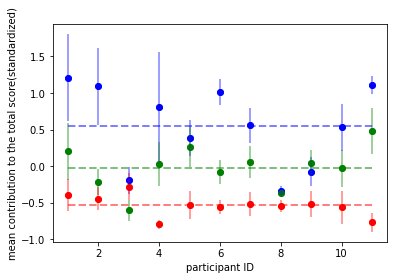

In [46]:
# Write your code here
fig, ax = plt.subplots()
ax.scatter(pd.unique(d.subjectId), b.gain_stand, color = "blue")
ax.scatter(pd.unique(d.subjectId), g.gain_stand, color = "green")
ax.scatter(pd.unique(d.subjectId), r.gain_stand, color = "red")
ax.errorbar(pd.unique(d.subjectId), b.gain_stand, yerr = b.err_bar, color= "blue", fmt='o', alpha= 0.5)
ax.errorbar(pd.unique(d.subjectId), g.gain_stand, yerr = g.err_bar, color= "green", fmt='o', alpha = 0.5)
ax.errorbar(pd.unique(d.subjectId), r.gain_stand, yerr = r.err_bar, color= "red", fmt='o', alpha = 0.5)
y_avg_b = [mean_avg_color_data[0]] * len(pd.unique(d.subjectId))
y_avg_g = [mean_avg_color_data[1]] * len(pd.unique(d.subjectId))
y_avg_r = [mean_avg_color_data[2]] * len(pd.unique(d.subjectId))
ax.plot(pd.unique(d.subjectId),y_avg_b , color='blue', lw=2, alpha = 0.5,  ls='--', label="average plot")
ax.plot(pd.unique(d.subjectId),y_avg_g , color='green', lw=2, alpha = 0.5,  ls='--', label="average plot")
ax.plot(pd.unique(d.subjectId),y_avg_r , color='red', lw=2, alpha = 0.5,  ls='--', label="average plot")
ax.set_ylabel("mean contribution to the total score(standardized)")
ax.set_xlabel("participant ID")

# Modeling Gains [85pts]

Consider the variables balloon color (C), participant/actor (A), and gain at a single trial (G). The DAG is given as:

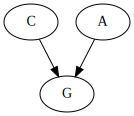

In [47]:
dot = Digraph()
dot.node('gain', 'G')
dot.node('color', 'C')
dot.node('actor', 'A')
dot.edge('color', 'gain')
dot.edge('actor', 'gain')
dot

**a.** First, discard the color and implement a Gaussian model for the relation between actor and gain. Use a Gaussian likelihood and assign a unique Gaussian prior for each actor. Create a model with a weak ($\sigma=1.5$) and another with a strong ($\sigma=0.1$) skeptical prior. Assign suitable priors for the model given below. **[20pts]**

Weak prior model:

$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{A[i]}
\\
\alpha_j &\sim ?
\\
\bar a &\sim \text{Normal}(0, 1.5)
\\
\sigma &\sim ?
\end{align*}
$$

Here different trials for a single subject will give important information, and we will use subject id's for the model.

In [48]:
# Write your code here (weak prior)
with pm.Model() as mAG:
    a_bar = pm.Normal('a_bar', 0, 1.5)
    sigma = pm.Exponential('sigma',1.5)
    a = pm.Normal('a', a_bar, sigma, shape = 12) # len(avg_gain_Data) + 1 gives error
    mu = pm.math.invlogit(a[avg_gain_Data.subjectId])
    G = pm.Normal('G', mu= mu, sigma = sigma , observed = avg_gain_Data.gain_stand)
    
    trace_mAG = pm.sample(2000, return_inferencedata = True)

az.summary(trace_mAG)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7090500504183582, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-2.552,0.646,-3.728,-1.351,0.032,0.023,402.0,702.0,1.01
a[0],-2.550,0.699,-3.893,-1.271,0.032,0.023,467.0,878.0,1.01
a[1],-2.536,0.708,-3.857,-1.180,0.033,0.023,469.0,864.0,1.01
a[2],-2.548,0.701,-3.813,-1.254,0.033,0.023,453.0,872.0,1.01
a[3],-2.585,0.680,-3.850,-1.333,0.031,0.022,477.0,844.0,1.01
a[4],-2.560,0.694,-3.901,-1.332,0.033,0.023,455.0,875.0,1.01
a[5],-2.559,0.692,-3.872,-1.292,0.033,0.023,453.0,832.0,1.01
a[6],-2.551,0.700,-3.863,-1.244,0.033,0.023,465.0,813.0,1.01
a[7],-2.561,0.694,-3.866,-1.291,0.032,0.023,470.0,919.0,1.01
a[8],-2.594,0.682,-3.885,-1.334,0.032,0.023,455.0,873.0,1.01


#### Analysis of weak sigma
As one can see due to assigning weak prior, we will have 1/3 of the samples as diverging. And the R hat score, ess scores are really bad and shows that this model does not give us a good predictive system such that one can use to make predictions and understand a behavior.

Strong prior model:

$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{A[i]}
\\
\alpha_j &\sim ?
\\
\bar a &\sim \text{Normal}(0, 0.1)
\\
\sigma &\sim ?
\end{align*}
$$

In [51]:
# Write your code here (strong prior)
with pm.Model() as mAG_strong:
    a_bar = pm.Normal('a_bar', 0, 0.1)
    sigma = pm.Exponential('sigma',0.1)
    a = pm.Normal('a', a_bar, sigma, shape = 12)
    mu = pm.math.invlogit(a[avg_gain_Data.subjectId])
    G = pm.Normal('G', mu= mu, sigma = sigma , observed = avg_gain_Data.gain_stand)
    
    trace_mAG_strong = pm.sample(2000, return_inferencedata = True)

az.summary(trace_mAG_strong)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.039,0.100,-0.231,0.142,0.001,0.001,6541.0,5298.0,1.0
a[0],-0.043,0.610,-1.183,1.126,0.005,0.008,12661.0,5444.0,1.0
a[1],-0.068,0.613,-1.143,1.187,0.005,0.007,13786.0,6016.0,1.0
a[2],-0.112,0.589,-1.181,1.047,0.006,0.007,10887.0,5542.0,1.0
a[3],-0.222,0.597,-1.273,0.978,0.006,0.007,10917.0,5708.0,1.0
a[4],-0.148,0.601,-1.333,0.952,0.005,0.007,13037.0,5830.0,1.0
a[5],-0.140,0.601,-1.273,0.996,0.005,0.008,12114.0,4509.0,1.0
a[6],-0.116,0.590,-1.224,1.005,0.005,0.007,12226.0,5242.0,1.0
a[7],-0.139,0.600,-1.240,1.066,0.006,0.007,11661.0,5647.0,1.0
a[8],-0.241,0.598,-1.347,0.919,0.006,0.007,11247.0,5985.0,1.0


#### Analysis of strong sigma
As one can see due to assigning strong prior now, we won't have any divergence, and  by that the R hat score, ess scores are really great and shows that this model can be used as a predictive model for the actor gain relation. 


# Part B

**b.** Is it possible to learn the strength of the prior from the data itself? If so, implement an appropriate hierarchical model and compare this model with the two in part *a* in terms of a predictive criterion. It is likely that you'll encounter some problems with this new model (since it is centered). Modify it as necessary (reparameterize to be non-centered). For each actor, plot the estimated means from each model on top of sample means. Use 89% HDI as errorbars on your estimated values. What seems to be the difference between these models. How $\sigma$ value affects model fit? **[20pts]**

Hierarchical version (centered):

$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{A[i]}
\\
...?
\end{align*}
$$

In [52]:
# Write your code here (centered model)
with pm.Model() as mAG_centered:
    a_bar = pm.Normal('a_bar', 0, 0.1)
    sigma = pm.Exponential('sigma',0.1)
    
    a = pm.Normal('a', a_bar, sigma, shape = 12)
    
    mu = pm.math.invlogit(a[avg_gain_Data.subjectId])
    
    G = pm.Normal('G', mu= mu, sigma = sigma , observed = avg_gain_Data.gain_stand)
    
    trace_mAG_centered = pm.sample(2000, return_inferencedata = True)

az.summary(trace_mAG_centered)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.040,0.100,-0.229,0.145,0.001,0.001,8223.0,5701.0,1.0
a[0],-0.037,0.629,-1.217,1.163,0.006,0.008,11397.0,5301.0,1.0
a[1],-0.074,0.605,-1.204,1.071,0.006,0.008,11890.0,5269.0,1.0
a[2],-0.125,0.600,-1.251,1.005,0.005,0.007,12013.0,5180.0,1.0
a[3],-0.227,0.595,-1.400,0.862,0.006,0.007,11479.0,5560.0,1.0
a[4],-0.147,0.613,-1.279,1.028,0.006,0.008,12303.0,5752.0,1.0
a[5],-0.131,0.615,-1.269,1.073,0.006,0.007,11977.0,4879.0,1.0
a[6],-0.123,0.618,-1.235,1.081,0.006,0.008,11299.0,5570.0,1.0
a[7],-0.134,0.606,-1.258,1.036,0.006,0.007,11854.0,5418.0,1.0
a[8],-0.225,0.617,-1.349,0.938,0.006,0.008,11903.0,5627.0,1.0


#### Centered - Comment
Centered model is actually nothing but a model that we used for strong and weak prior.

Hierarchical version (non-centered):

$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{A[i]}
\\
...?
\end{align*}
$$

In [53]:
# Write your code here (non-centered model)
with pm.Model() as mAG_non_centered:
    a_bar = pm.Normal('a_bar', 0, 0.1)
    sigma = pm.Exponential('sigma',1)
    
    z = pm.Normal('z', 0, 0.1, shape = 12)
    
    mu = pm.math.invlogit(a_bar + z[avg_gain_Data.subjectId] * sigma)
    
    G = pm.Normal('G', mu= mu, sigma = sigma , observed =avg_gain_Data.gain_stand)
    
    trace_mAG_non_centered = pm.sample(2000, return_inferencedata = True)

az.summary(trace_mAG_non_centered)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.044,0.101,-0.237,0.143,0.001,0.001,9761.0,6286.0,1.0
z[0],-0.001,0.101,-0.192,0.184,0.001,0.001,10292.0,6123.0,1.0
z[1],-0.002,0.101,-0.196,0.185,0.001,0.001,11171.0,6255.0,1.0
z[2],-0.001,0.098,-0.183,0.180,0.001,0.001,10291.0,6072.0,1.0
z[3],-0.003,0.097,-0.195,0.168,0.001,0.001,9520.0,6170.0,1.0
z[4],-0.002,0.099,-0.198,0.176,0.001,0.001,12009.0,6172.0,1.0
z[5],-0.001,0.102,-0.190,0.191,0.001,0.001,11470.0,6219.0,1.0
z[6],-0.002,0.099,-0.180,0.192,0.001,0.001,9314.0,6185.0,1.0
z[7],-0.003,0.098,-0.187,0.183,0.001,0.001,10169.0,6225.0,1.0
z[8],-0.005,0.100,-0.193,0.180,0.001,0.001,10693.0,5567.0,1.0


In [55]:
# Write your code here (non-centered model)
with pm.Model() as ma:
    a_bar = pm.Normal('a_bar', 0, 0.1)
    sigma = pm.Exponential('sigma',1)
    
    z = pm.Normal('z', 0, 0.1, shape = 12)
    
    mu = pm.math.invlogit(a_bar + z[avg_gain_Data.subjectId] * sigma)
    
    G = pm.Normal('G', mu= mu, sigma = sigma , observed =avg_gain_Data.gain_stand)
    
    trace_a = pm.sample(2000, return_inferencedata = True)

az.summary(trace_a, hdi_prob = 0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.046,0.100,-0.212,0.101,0.001,0.001,10663.0,6055.0,1.0
z[0],-0.000,0.100,-0.162,0.156,0.001,0.001,10075.0,6159.0,1.0
z[1],0.001,0.099,-0.152,0.163,0.001,0.001,9297.0,6008.0,1.0
z[2],-0.002,0.101,-0.163,0.156,0.001,0.001,10052.0,6315.0,1.0
z[3],-0.003,0.100,-0.160,0.159,0.001,0.001,11322.0,6329.0,1.0
z[4],-0.002,0.099,-0.151,0.166,0.001,0.001,10664.0,6302.0,1.0
z[5],-0.001,0.101,-0.170,0.150,0.001,0.001,10774.0,5949.0,1.0
z[6],-0.001,0.100,-0.158,0.162,0.001,0.001,11184.0,5738.0,1.0
z[7],-0.003,0.099,-0.158,0.161,0.001,0.001,8586.0,6032.0,1.0
z[8],-0.003,0.099,-0.154,0.161,0.001,0.001,11168.0,6104.0,1.0


#### Non-centered commentary
Non - centered considers a_bar which gives us mean predictions considered in the logistic model.

Each one has the average of the gain_standard.

In [ ]:
az.summary(trace_mAG_non_centered.posterior.z)

array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

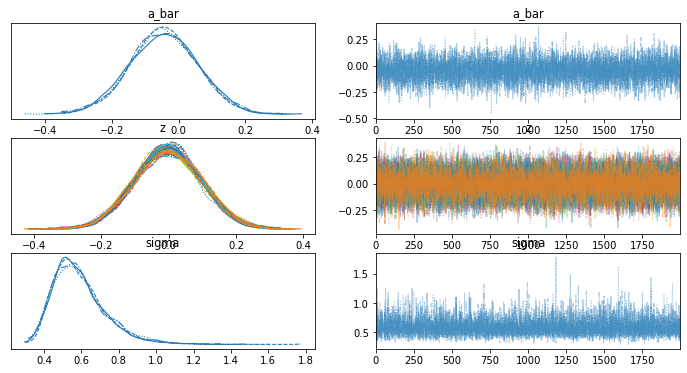

In [58]:
az.plot_trace(trace_mAG_non_centered)

In [60]:
# Write your code here (model comparison)
compare_dict = {"strong_prior":trace_mAG_strong,"weak_prior": trace_mAG, "non_centered":trace_mAG_non_centered, "centered":trace_mAG_centered }

az.compare(compare_dict, ic ="loo")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
weak_prior,0,-1.415351,1.283829,0.000000,1.000000e+00,2.462219,0.000000,False,log
non_centered,1,-9.573556,0.443853,8.158205,0.000000e+00,1.454330,1.327684,False,log
strong_prior,2,-9.622018,0.904262,8.206667,3.164136e-15,1.375047,1.372920,False,log
centered,3,-9.673649,0.939373,8.258298,0.000000e+00,1.386567,1.359597,False,log


Apparently weak prior is the most powerful one with most divergence in the system, it would have been expected that non_centered or strong prior to be the best in predictive performance, since standard error of the weak is higher, p_loo performance is lower. weight is higher than non_centered. But the system shows that weak is the best. The second best is however as expected is non_centered model. 

Probably some mistake happened in the system for weak, and it is seen as the best.

ValueError: could not convert string to float: 'posterior'

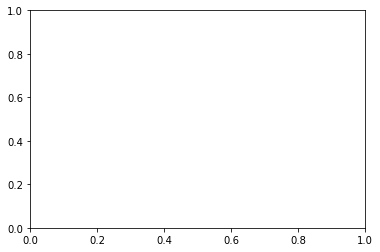

In [74]:
# Write your code here (plots) [Hint: your plot should look like the one below]
fig, ax = plt.subplots()
ax.scatter(trace_mAG_non_centered,trace_mAG_non_centered, color = "blue")
ax.scatter(trace_mAG_non_centered,trace_mAG_centered, color = "green")
ax.scatter(trace_mAG_non_centered,trace_mAG_strong, color = "red")
ax.set_ylabel("mean contribution to the total score(standardized)")
ax.set_xlabel("participant ID")

# I couldn't manage to make a plot.

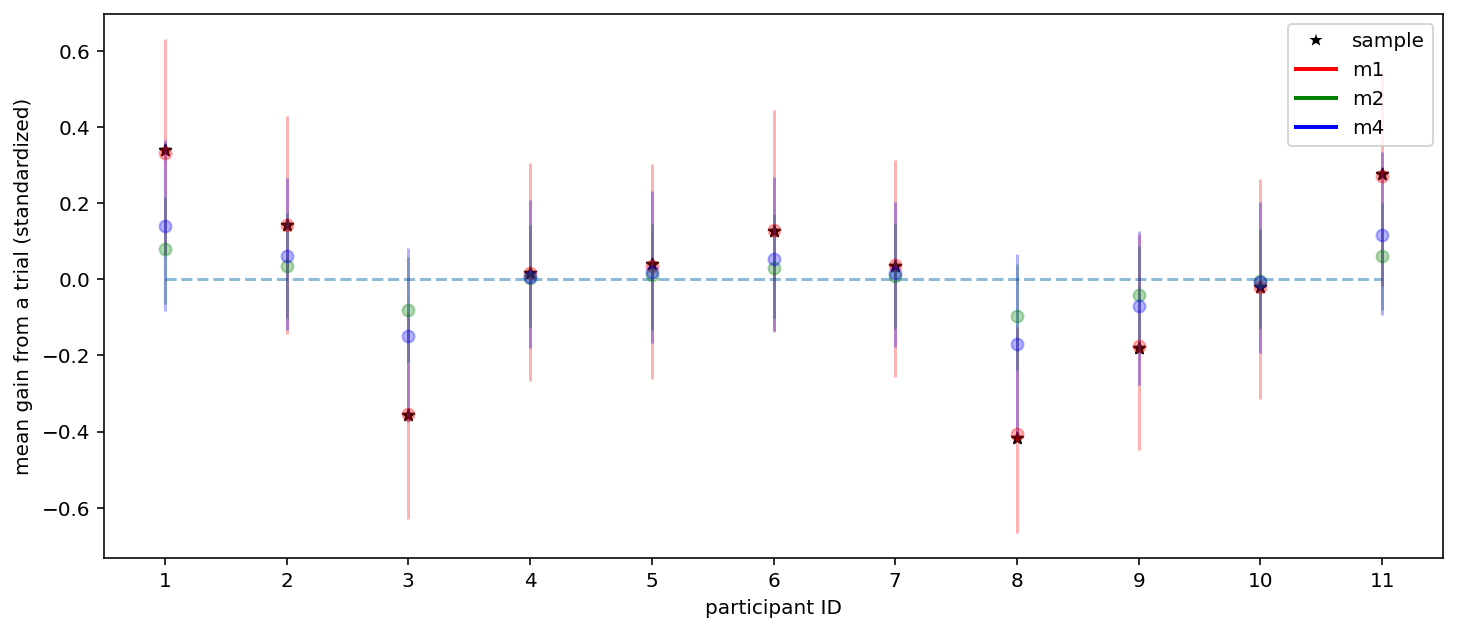

In [54]:
Image('output4.png')

**Your explanation goes here.**

The explanations are given right after the comparisons and the models are made. 

## Part C

**c.** Note that the experiment has 3 treatments (i.e. 3 different balloon colors). Create a model for the gains, but this time add a term for the treatments (i.e. consider treatments as another cluster). Implement a non-centered version. Plot the posterior distributions for treatment intercepts. How do you interpret them? **[20pts]**

The non-centered model:

$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \bar{\alpha} +  \text{z}_{A[i]} \times \sigma_{\alpha} + \beta_{T[i]}
\\
...?
\end{align*}
$$

In [82]:
avg_color_data["color_num"] = pd.Categorical(avg_color_data["color"]).codes 

In [84]:
# Write your code here (non-centered model)
with pm.Model() as mAG_non_centered_color:
    a_bar = pm.Normal('a_bar', 0, 0.1)
    sigma = pm.Exponential('sigma',1)
    
    z = pm.Normal('z', 0, 0.1, shape = 34)
    bP = pm.Normal('bP', 0, 0.1)

    mu = pm.math.invlogit(a_bar + z[avg_color_data.subjectId] * sigma + bP*avg_color_data.color_num)
    
    G = pm.Normal('G', mu= mu, sigma = sigma , observed =avg_color_data.gain_stand)
    
    trace_mAG_non_centered_color = pm.sample(2000, return_inferencedata = True)

az.summary(trace_mAG_non_centered_color)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bP, z, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.070,0.098,-0.253,0.118,0.001,0.001,21428.0,5819.0,1.0
z[0],0.000,0.097,-0.188,0.176,0.001,0.001,17802.0,5271.0,1.0
z[1],-0.001,0.100,-0.181,0.190,0.001,0.001,21422.0,5850.0,1.0
z[2],-0.003,0.102,-0.193,0.189,0.001,0.001,18684.0,5361.0,1.0
z[3],-0.008,0.099,-0.189,0.178,0.001,0.001,16817.0,5592.0,1.0
z[4],-0.004,0.098,-0.177,0.185,0.001,0.001,17928.0,5836.0,1.0
z[5],-0.003,0.100,-0.191,0.190,0.001,0.001,19820.0,5093.0,1.0
z[6],-0.003,0.101,-0.195,0.182,0.001,0.001,17061.0,5529.0,1.0
z[7],-0.003,0.100,-0.191,0.183,0.001,0.001,17708.0,5450.0,1.0
z[8],-0.008,0.099,-0.191,0.178,0.001,0.001,19593.0,5138.0,1.0


In [75]:
len(avg_color_data) 

33

It seems from the Z_8, Z_9, Z_10, third actor got affected the most from the color treatment to the system. 

The others for my model looks similar. 

<ipython-input-89-70860f5fa27d>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  _ = pm.traceplot(trace_mAG_non_centered_color.posterior.z)


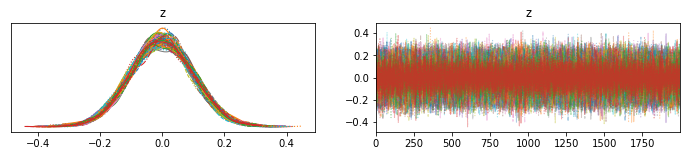

In [89]:
# Write your code here (for posterior distributions)
_ = pm.traceplot(trace_mAG_non_centered_color.posterior.z)

**Your explanation goes here.**

### Explanation
Maybe the approach used above is mistaken, but what is done gave a standardized z for most and we can't clearly see the third actor in the z due to many of the posterior distributions are similar to each other and the third is not that different from the rest.

## Part D

**d.** When we've plotted the gains for different colors of balloons, we've seen that not all actors are similarly affected by the color treatment. In the previous model we added the treatment term as a single parameter. Now modify your model which can account for the covarying actor-treatment effects. (Hint: you need to use a multivariate normal distribution). In other words, take balloon color to be a feature, rather than a cluster. Again, since the centered version probably will not sample adequately, implement a non-centered version. **[25pts]**
- Plot the estimated mean for each actor, as you did before. How this model, which can account for covariance, is different from the previous model where the treatment effects were not considered at all. Compare the two using a predictive criterion.
- Visualize the estimated covariance term. Plot the sample means for gains from each balloon color, for each participant (as you did before), and plot the estimated means.

The non-centered model:
$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \bar{\alpha}_{A[i]} +  \alpha_{A[i],T[i]}
\\
...?
\end{align*}
$$

In [115]:
# Write your code here (non-centered model)
with pm.Model() as mAG_non_centered_color_d:
    chol, Rho, sigma_color = pm.LKJCholeskyCov("chol_cov", n = 2, eta = 4,
                                              sd_dist = pm.Exponential.dist(1.0), compute_corr = True)
    a_bar = pm.Normal('a_bar', 0, 0.1)
    bP = pm.Normal('bP', 0, 0.1)
    sigma_within = pm.Exponential('sigma_within',1)
    
    ab_part_D = pm.MvNormal('ab_part_D', mu = pm.math.stack([a_bar, bP]), chol = chol, shape = (34,2))
   

    mu = pm.math.invlogit(a_bar + ab_part_D[avg_color_data.subjectId, 0] + ab_part_D[avg_color_data.subjectId, 1] + ab_part_D[avg_color_data.subjectId, 2])
    
    G = pm.Normal('G', mu= mu, sigma = sigma_within , observed =avg_color_data.gain_stand)
    
    trace_mAG_non_centered_color_d = pm.sample(2000, return_inferencedata = True)

az.summary(trace_mAG_non_centered_color_d)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_part_D, sigma_within, bP, a_bar, chol_cov]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 95 seconds.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5655257853687709, but should be close to 0.8. Try to increase the number of tuning steps.
There were 334 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7044170562633881, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.074,0.102,-0.266,0.115,0.005,0.004,419.0,1040.0,1.01
bP,-0.040,0.104,-0.245,0.157,0.006,0.004,330.0,281.0,1.01
"ab_part_D[0, 0]",-0.077,1.780,-3.623,3.429,0.048,0.066,1217.0,486.0,1.02
"ab_part_D[0, 1]",-0.096,1.828,-3.453,3.295,0.071,0.078,2256.0,606.0,1.01
"ab_part_D[1, 0]",-0.448,1.715,-4.047,2.310,0.081,0.060,787.0,232.0,1.02
...,...,...,...,...,...,...,...,...,...
"chol_cov_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"chol_cov_corr[0, 1]",-0.016,0.340,-0.660,0.596,0.011,0.011,846.0,453.0,1.01
"chol_cov_corr[1, 0]",-0.016,0.340,-0.660,0.596,0.011,0.011,846.0,453.0,1.01
"chol_cov_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,3308.0,2151.0,1.00


## Commentary on the code model

Here as given above and below, different color effects are shown in weird way. 33 shape indicates colors are already considered for each individual actor, however we have a shape 2 in the second part for color which makes me question what is actually going on with the model.

Tried to learn pymc better with the hierarchical models, but couldn't accomplish to use them well.

R_hat values are still good but not 1

In [121]:
# Write your code here (posterior means)
az.summary(trace_mAG_non_centered_color_d.posterior.ab_part_D)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ab_part_D[0, 0]",-0.077,1.780,-3.623,3.429,0.048,0.066,1217.0,486.0,1.02
"ab_part_D[0, 1]",-0.096,1.828,-3.453,3.295,0.071,0.078,2256.0,606.0,1.01
"ab_part_D[1, 0]",-0.448,1.715,-4.047,2.310,0.081,0.060,787.0,232.0,1.02
"ab_part_D[1, 1]",-0.272,1.412,-3.052,2.332,0.036,0.039,1705.0,837.0,1.02
"ab_part_D[2, 0]",-0.600,1.637,-4.053,1.829,0.067,0.054,617.0,570.0,1.02
...,...,...,...,...,...,...,...,...,...
"ab_part_D[31, 1]",-0.047,1.633,-3.067,3.213,0.022,0.048,5008.0,1011.0,1.01
"ab_part_D[32, 0]",-0.030,1.786,-3.138,3.512,0.036,0.054,1613.0,720.0,1.02
"ab_part_D[32, 1]",-0.028,1.641,-3.290,3.087,0.023,0.044,4919.0,1142.0,1.01
"ab_part_D[33, 0]",-0.164,1.840,-3.610,3.889,0.060,0.069,1113.0,278.0,1.02


In [134]:
# Write your code here (model comparison)
compare_dict1 = {"color_non_centered_multivariate":trace_mAG_non_centered_color_d,"non_centered_color":trace_mAG_non_centered_color}

az.compare(compare_dict1, ic ="loo")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
color_non_centered_multivariate,0,-36.081815,4.614887,0.000000,0.664528,2.614670,0.000000,False,log
non_centered_color,1,-36.358858,0.441512,0.277043,0.335472,2.301452,1.339642,False,log


**Your explanation goes here.**

Had many problems with the observation dimensions to be able to compare, but later on realized that we were using the non_color one in the comparison then changed it to the non_centered_color then the result came out.

1) It seems that color_non_centered_multivariate is better which is normally what we expect however, as seen from the p_loo scores, CNCM has a higher score which shows misprediction, that may be due to divergences in the system. 

2) standard error again is higher which is in normal cases would indicate the model is worse, however the models are compared mostly  for the loo parameter which is best for CNCM. 

<ipython-input-131-d20ccc6b4f46>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  _ = pm.traceplot(trace_mAG_non_centered_color_d.posterior.chol_cov_corr)
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\ProgramData\Anaconda3\lib\site-p

OverflowError: cannot convert float infinity to integer

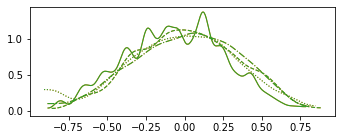

In [131]:
# Write your code here (plot for estimated covariance term) [Hint: your plot should look like the one below]
_ = pm.traceplot(trace_mAG_non_centered_color_d.posterior.chol_cov_corr)

Here it didn't give the result directly but at the below so I downloaded it and inserted as an image to below of this description.

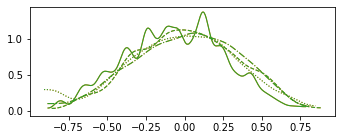

In [132]:
Image('download.png')

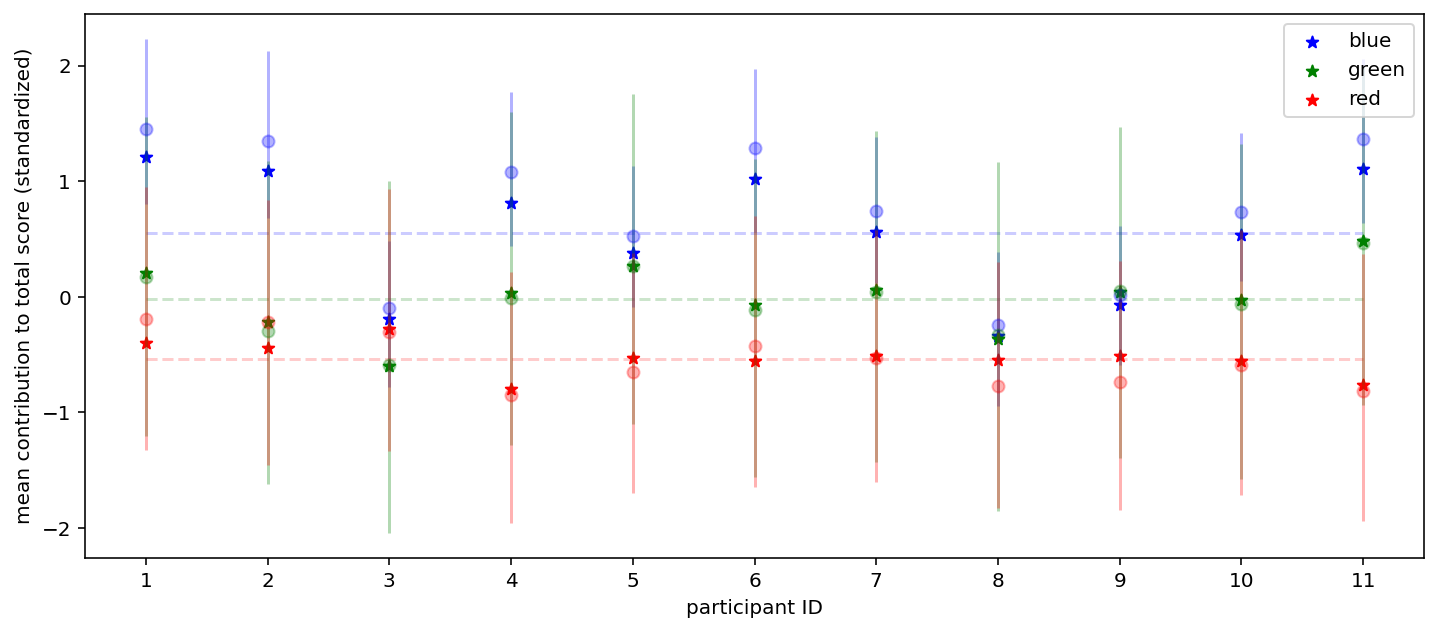

In [90]:
Image('output5.png')

In [135]:
# No clue how to do it.

# Modeling Decisions [BONUS] [70pts]

So far, we've been using statistical devices to fit a model to observed data. In previous sections we focused on the score as the outcome. However, what a subject actually does is to basically the decide on whether to pump or cash-in on the $k^{th}$ opportunity within the $i^{th}$ trial. Wallsten et al. (2005) provides cognitive process models for this task (mathematical models with psychological interpretation). van Ravenzwaaij et al. (2011) proposes a simplified model, and extends it with hierarchical Bayesian models. These models are also discussed in Lee & Wagenmakers (2014), chapter 16. You can see the chapter and papers for details, if you're interested.

Consider the model below:
$$ \gamma^{+}: \text{Propensity for risk taking} $$
$$ \beta: \text{Behavioral consistency} $$
$$ p: \text{Burst probability}$$
$$ \omega = -\gamma^{+} \,/\,\text{log}(1-p) $$
$$ \theta_{jk} = \frac{1} {1+e^{\beta(k-\omega)}} $$
$$ d_{jk} \sim \text{Bernoulli}(\theta_{jk}) $$
In this model:
- the subject is assumed to be informed about the actual burst probability, and $p$ is the belief of bursting probability for a subject (you can take it as constant, average of burst probabilities of each balloon, i.e. $(1/16+1/32+1/64)/3$)
- $k$ is the number of the opportunity
- $j$ is the number of the trial
- $\omega$ is the number of pumps the subject considers optimal
- $\theta_{jk}$ is the probability that the subject decides to pump on the $k^{th}$ opportunity within the $j^{th}$ trial
- $\gamma^{+} \geq 0$; $\beta \geq 0$; $\omega \geq 0$
- $0 \leq p \leq 1$; $0 \leq \theta_{jk} \leq 1$
- $d_{jk} \in \{1,0\}$ (pump, cash-in)
- log is the natural logarithm, $ln$

## Cognitive Process Model [15pts]
What are the psychological implications of the model? Briefly describe your interpretations for different values of $p$, $\beta$, and $\gamma^{+}$.

- Plot $\omega$ against $1/64 \leq p \leq 1/32$, for $\gamma^{+} \in \{0.0, 0.25, 0.5, ...1.75, 2.0\}$ on one graph. What's the interpretation?
- Plot $\omega$ against $0 \leq \gamma^{+} \leq 2$, for $p \in \{1/16, 1/32, 1/64 \}$ on another graph. What's the interpretation?
- Plot $\theta_{jk}$ against $0 \leq \beta \leq 1.2$ for $\delta \in \{-15, -14,..., 0,..., 14, 15\}$ on another graph where $\delta = k - \omega$. What happens to decision probability $\theta_{jk}$ when $\beta = 0$

In [ ]:
# Code here

**Explanation**

In [ ]:
# Code here

**Explanation**

In [ ]:
# Code here

**Explanation**

In [ ]:
# Hint: expected plots are as follows:
Image('output6.png')

In [ ]:
Image('output7.png')

In [ ]:
Image('output8.png')

## Model in PyMC [55pts]
In this section you are asked to implement the model.

We need to extend the dataset. We are not interested in scores now. We can create a new `DataFrame` with columns holding participant number, balloon color, opportunity, and decision. We can think of opportunity as a decision counter for each trial. Decision is whether subject pumped or not on that particular opportunity. So, for example if the original dataset has a row where `subjectId` is 5,`nPump` is 3, `burst` is 0, and `color` is red, then this means that the participant had 4 opportunities where for the first 3 they pumped, and in the last one they decided to cash in. So the corresponding part of the new `DataFrame` may look like something like the one below.

In [ ]:
example_df = pd.DataFrame(columns=["ID", "color", "opportunity", "decision"])
example_df.loc[0] = [5, 'blue', 1, 1]
example_df.loc[1] = [5, 'blue', 2, 1]
example_df.loc[2] = [5, 'blue', 3, 1]
example_df.loc[3] = [5, 'blue', 4, 0]
example_df

The code for this adjustment is given below:

In [ ]:
df = pd.read_csv('BART_data.csv')
ddf = pd.DataFrame(columns=["ID", "color", "opportunity", "decision"])
global_counter = 0
for index, row in df.iterrows(): # for each trial
    id = row.subjectId
    color = row.color
    if color == 'blue':
        c = 0
    elif color == 'green':
        c = 1
    else:
        c = 2
    opportunity = 0
    for p in range(row.nPump): # for each pump
        decision = 1 # add the decision to pump
        opportunity += 1 # each decision shows an opportunity taken
        ddf.loc[global_counter] = [id, c, opportunity, decision]
        global_counter += 1
    if row.burst: # if the balloon bursts
        decision = 1 # it means subject decided to pump one last time
        opportunity += 1
        ddf.loc[global_counter] = [id, c, opportunity, decision]
        global_counter += 1       
    else: # if not, then they cashed-in
        decision = 0
        opportunity += 1
        ddf.loc[global_counter] = [id, c, opportunity, decision]
        global_counter += 1
ddf = ddf.astype(int)
ddf.head()

**a.** Implement the cognitive process model in pymc, without considering the color. Select appropriate priors for behavioral consistency and risk taking parameters, based on your interpretation of the cognitive process model. Draw the graphical depiction of the model, and show the posterior distributions of risk taking and behavioral consistency for each participant, together with a histogram of number of pumps. Which participant seems to have the highest risk taking value? Which participant is the most behaviorally consistent one? **[25pts]**
- Hint: since we're not considering the color effect, you can take p as the average burst probability of three colors.
- Hint: you can use `model_to_graphviz()` from pymc to get a graphic depiction of the model
- Hint: definition of $\theta_{jk}$ should be familiar from somewhere (i.e. $1/(1+e^{-x})$)

 $$
 \begin{align*}
 \gamma^{+}_i &\sim \text{?}
 \\
 \beta_i &\sim \text{?}
 \\
 \omega_i &= -\gamma^{+}_i \,/\,\text{log}(1-p) 
 \\
 \theta_{jk} &= \frac{1} {1+e^{\beta(k-\omega)}} 
 \\
 d_{jk} &\sim \text{Bernoulli}(\theta_{jk})     
 \end{align*}
 $$

In [ ]:
# Model definition here
p = (1/16+1/32+1/64)/3
# ...

In [ ]:
# Histogram - posterior risk taking - posterior behavioral consistency plots for each actor (a 11 x 3 plot)

**b.** The model in part 'a' has no memory. Learning about a participant's behavior does not influence others. Create a hierarchical version of the model which has a structural relationship between participants. You can do this by assigning population priors to risk taking and behavioral consistency parameters. Also, the model in part 'a' does not account for the effect of balloon colors. Add a prior for $p$, the belief of burst probability, make sure that it accounts for the interaction between actors and balloon colors. Plot the posterior distributions for population priors for the $\gamma$ and $\sigma$ means, and for the interaction term for $p$. (Hint: use multivariate normal for interaction term) **[30pts]**

In [ ]:
# Hint: you can use variational inference as follows (to be used in your model):
chains = 4 # you can change this
approx = pm.fit(
        n=100000, method="advi", obj_optimizer=pm.adagrad_window
    )
start = approx.sample(draws=chains, include_transformed=True)
trace = pm.sample(
         tune=2000, target_accept=0.95, chains=chains, init="adapt_diag", start=list(start)
    )

In [ ]:
# Model definition here

In [ ]:
# Posterior plots here

## References
Lee, M. D., & Wagenmakers, E. J. (2014). Bayesian cognitive modeling: A practical course. Cambridge university press.

van Ravenzwaaij, D., Dutilh, G., & Wagenmakers, E. J. (2011). Cognitive model decomposition of the BART: Assessment and application. Journal of Mathematical Psychology, 55(1), 94-105.

Wallsten, T. S., Pleskac, T. J., & Lejuez, C. W. (2005). Modeling behavior in a clinically diagnostic sequential risk-taking task. Psychological review, 112(4), 862.